Goal: Sample bitstrings of length BITSTRING_LENGTH such that the elements sum to prime numbers

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm
import matplotlib.pyplot as pp

In [2]:
BITSTRING_LENGTH = 8

In [3]:
def reward(state):
  sum = state.sum()
  if sum <= 1:
    return 100
  for i in range(2, int(sum**0.5) + 1):
    if sum % i == 0:
      return 100
  return 500

In [4]:
class FlowModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    self.mlp = nn.Sequential(nn.Linear(BITSTRING_LENGTH, num_hid),
                             nn.LeakyReLU(),
                             nn.Linear(num_hid, 1))
  def forward(self, x):
    flow = torch.nn.functional.softplus(self.mlp(x))
    return flow

In [5]:
class PForward(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    self.mlp = nn.Sequential(nn.Linear(BITSTRING_LENGTH, num_hid),
                             nn.LeakyReLU(),
                             nn.Linear(num_hid, BITSTRING_LENGTH+1))
  def forward(self, x):
    p_forward = torch.nn.functional.softmax(self.mlp(x), dim=0)
    return p_forward

$$L(s,s') = \left(F(s)Pf(s'|s)-F(s')Pb(s|s')\right)^2$$

In [6]:
flow_model = FlowModel(512)
p_forward_model = PForward(512)
# double check
opt = torch.optim.Adam(list(flow_model.parameters()) + list(p_forward_model.parameters()), 3e-4)

rewards = []
losses = []
sampled_bitstrings = []
minibatch_loss = torch.zeros(1)
minibatch_reward = 0
update_freq = 5

for episode in tqdm.tqdm(range(10000), ncols=40):
  state = torch.zeros(BITSTRING_LENGTH)
  flow_s = flow_model(state)
  pf = p_forward_model(state)
  while True:
    # rule out actions that make state[i] = 1 if state[i] = 1 already
    possible_actions = torch.logical_not(torch.cat((state, torch.tensor([0])))) * pf
    policy = possible_actions / possible_actions.sum()
    action = Categorical(probs=policy).sample()

    #calculate loss
    #exit state
    if action == BITSTRING_LENGTH:
      rs = reward(new_state)
      minibatch_reward += rs
      loss = (flow_s*policy[action]-rs).pow(2)
      break
    else:
      new_state = state.clone()
      new_state[action] = 1
      pb = 1/new_state.sum()
      flow_sp = flow_model(new_state)
      loss = (flow_s*policy[action]-flow_sp*pb).pow(2)
      state = new_state.clone()

    minibatch_loss += loss

  sampled_bitstrings.append(state)
  if episode % update_freq == 0:
    losses.append(minibatch_loss.item())
    rewards.append(minibatch_reward/update_freq)
    if minibatch_loss != 0:
      minibatch_loss.backward()
      opt.step()
      opt.zero_grad()
    minibatch_loss = torch.zeros(1)
    minibatch_reward = 0

100%|█| 10000/10000 [00:09<00:00, 1081.1


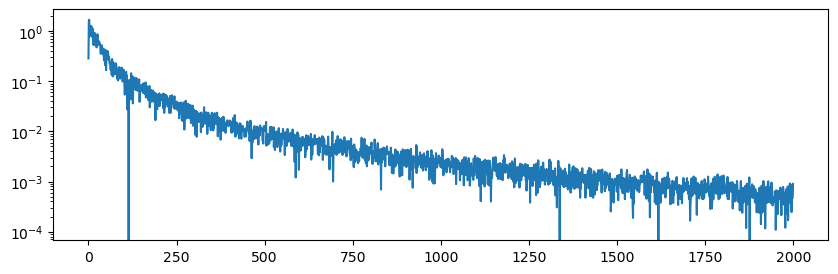

In [7]:
pp.figure(figsize=(10,3))
pp.plot(losses)
pp.yscale('log')